In [1]:
import numpy as np
import pandas as pd
import nltk
import scipy as sp
import sklearn as sk
import os,time,re,string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn import metrics

* 大概思路：利用正负面描述的 **词语频率** 预测Amazon的商品评价
    1. 读取文字描述，查看大概数据情况
    2. 整理标签(>3 stars = positive)
    3. 整理summary文字，并建立语料库
    4. 建模
    5. 结果

# 1. Data Exploration

In [2]:
review_raw = pd.read_csv('./data/Reviews.csv')

In [3]:
review_raw.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
review_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
review_raw.isnull().sum(axis=0)

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [6]:
review_raw.Score.unique().shape[0]

5

In [7]:
n_samples = review_raw.shape[0]
n_samples

568454

In [8]:
df_uni = pd.DataFrame(index=range(10),
                      columns=['Feature','No. of NAs','No. of Unique Values','# of total samples','Unique_Percentage(%)'])


In [9]:
df_uni

,Feature,No. of NAs,No. of Unique Values,# of total samples,Unique_Percentage(%)
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [10]:
review_raw.columns.values

array(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype=object)

In [11]:
for i,feat in enumerate(review_raw.columns.values):
    feat_na = review_raw[feat].isnull().sum(axis=0)
    feat_uni = review_raw[feat].unique().shape[0]
    perc = feat_uni/n_samples * 100
    df_uni.iloc[i,:] = [feat, feat_na,feat_uni, n_samples, perc]

In [12]:
df_uni

,Feature,No. of NAs,No. of Unique Values,# of total samples,Unique_Percentage(%)
0,Id,0,568454,568454,100
1,ProductId,0,74258,568454,13.0632
2,UserId,0,256059,568454,45.0448
3,ProfileName,16,218417,568454,38.423
4,HelpfulnessNumerator,0,231,568454,0.0406365
5,HelpfulnessDenominator,0,234,568454,0.0411643
6,Score,0,5,568454,0.000879579
7,Time,0,3168,568454,0.557301
8,Summary,27,295743,568454,52.0258
9,Text,0,393579,568454,69.2367


In [13]:
review = review_raw.dropna()

In [14]:
review.shape

(568411, 10)

# 2. 整理label, 作为正负评价的标签
* 将结果分为两类: positive (score > 3) and negative (score <= 3)

In [15]:
label = review['Score'].apply(lambda x: 1 if x>3 else 0 )

In [16]:
label.head()

0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64

# 3 整理summary文字栏

* 去标点等符号
* 分词
* stopwords,去掉stopwords
* 词干提取Stemming与词形还原Lemmatization
* 清洗结果对比

In [17]:
summary = review['Summary']
summary.head()

0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Summary, dtype: object

## 3.1 数据清洗: 去掉标点符号
* 不要忘记import string
* import string
* string.punctuation

In [18]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
trantable = str.maketrans('','',string.punctuation)
def data_clean(text):
    text = text.lower()
    text_clean = text.translate(trantable)
    return text_clean

In [20]:
# test
l1 = 'hi, whats up*^@^*&!@#...'
data_clean(l1)

'hi whats up'

# Issue 1 -  str.maketrans('','',string.punctuation)
```python
import string
# This uses the 3-argument version of str.maketrans with arguments (x, y, z) where 'x' and 'y'
# must be equal-length strings and characters in 'x' are replaced by characters in 'y'. 
# 'z' is a string(string.punctuation here) where each character in the string is mapped to None
translator = str.maketrans('', '', string.punctuation)
s = 'string with "punctuation" inside of it! Does this work? I hope so.'
print(s.translate(translator))
=> string with punctuation inside of it Does this work I hope so
```

# Explaination 

```python
str.maketrans('abc', 'xyz', 'hij')

# This is the same as the two argument version, except that the characters from the third string are removed, 
# as if they were mapped to None. 
# So your table is saying "Don't replace anything, but remove the characters that show up in this string".
```
<p style='color:red'>Don't replace anything, but remove the characters that show up in this string</p>
**Don't replace anything, but remove the characters that show up in this string**

reference: [How to explain the str.maketrans function in Python 3.6?](https://stackoverflow.com/questions/41535571/how-to-explain-the-str-maketrans-function-in-python-3-6#41536036)

In [21]:
summary = summary.apply(lambda x: data_clean(x))

In [22]:
summary.head()

0    good quality dog food
1        not as advertised
2      delight says it all
3           cough medicine
4              great taffy
Name: Summary, dtype: object

## 3.2 分词 tokenize

In [23]:
from nltk import word_tokenize
demo = summary[:5000]
corpus_w_stopword = [word_tokenize(text) for text in demo]

In [24]:
corpus_w_stopword[:10]

[['good', 'quality', 'dog', 'food'],
 ['not', 'as', 'advertised'],
 ['delight', 'says', 'it', 'all'],
 ['cough', 'medicine'],
 ['great', 'taffy'],
 ['nice', 'taffy'],
 ['great', 'just', 'as', 'good', 'as', 'the', 'expensive', 'brands'],
 ['wonderful', 'tasty', 'taffy'],
 ['yay', 'barley'],
 ['healthy', 'dog', 'food']]

## 3.3 去掉停用词 stopwords

corpus:全集，文集; 资金，本金; [计] 语料库; 器官

In [25]:
from nltk import FreqDist
from nltk.corpus import stopwords

In [26]:
# stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',

In [27]:
def remove_stopword(text):
    return [word for word in text if word not in stopwords.words('english')]

In [28]:
corpus_wo_stopword = [remove_stopword(text) for text in corpus_w_stopword]

In [29]:
corpus_wo_stopword[:10]

[['good', 'quality', 'dog', 'food'],
 ['advertised'],
 ['delight', 'says'],
 ['cough', 'medicine'],
 ['great', 'taffy'],
 ['nice', 'taffy'],
 ['great', 'good', 'expensive', 'brands'],
 ['wonderful', 'tasty', 'taffy'],
 ['yay', 'barley'],
 ['healthy', 'dog', 'food']]

- list.append()
- list.extend()
- np.hstack() 效果同于list.extend()，打破原来的子列表，组合成只有word的整体list

In [30]:
corpus_wo_h = np.hstack(corpus_wo_stopword)

In [31]:
corpus_w_h = np.hstack(corpus_w_stopword)

In [110]:
corpus_wo_h

array(['good', 'quality', 'dog', ..., 'great', 'healthy', 'snack'],
      dtype='<U32')

In [32]:
print('Unduplicated words without stopwords: {}'.format(len(set(corpus_wo_h))))
print('Unduplicated words with stopwords: {}'.format(len(set(corpus_w_h))))

Unduplicated words without stopwords: 3187
Unduplicated words with stopwords: 3301


## 3.4 词干提取和词性还原 - 时态，单复数

In [33]:
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

In [34]:
porter = PorterStemmer()
wnl = WordNetLemmatizer()

In [35]:
print('eating 词干是: {}'.format(porter.stem('eating')))
print('feet 词性还原是: {}'.format(wnl.lemmatize('feet')))

eating 词干是: eat
feet 词性还原是: foot


In [36]:
stem_wo = [porter.stem(word) for word in corpus_wo_h]
lem_wo = [wnl.lemmatize(word) for word in corpus_wo_h]

In [117]:
# stem_wo

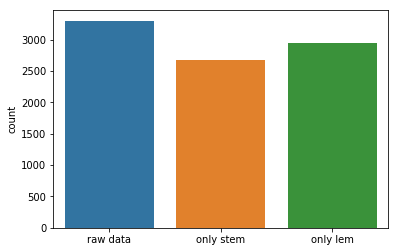

In [37]:
plt.figure()
sns.barplot(x = ['raw data','only stem','only lem'],
            y = [len(set(corpus_w_h)),len(set(stem_wo)),len(set(lem_wo))])
plt.ylabel('count')
plt.show()

- 去粗stopwords后的词频

In [38]:
# FreqDist(corpus_wo_h)

FreqDist({'good': 479,
          'quality': 47,
          'dog': 122,
          'food': 136,
          'advertised': 3,
          'delight': 7,
          'says': 3,
          'cough': 2,
          'medicine': 1,
          'great': 690,
          'taffy': 4,
          'nice': 48,
          'expensive': 21,
          'brands': 3,
          'wonderful': 44,

In [39]:
# list(FreqDist(corpus_wo_h).items())

[('good', 479),
 ('quality', 47),
 ('dog', 122),
 ('food', 136),
 ('advertised', 3),
 ('delight', 7),
 ('says', 3),
 ('cough', 2),
 ('medicine', 1),
 ('great', 690),
 ('taffy', 4),
 ('nice', 48),
 ('expensive', 21),
 ('brands', 3),
 ('wonderful', 44),
 ('tasty', 91),
 ('yay', 2),
 ('barley', 2),
 ('healthy', 63),

In [40]:
FreqDist(corpus_wo_h).most_common(10)

[('great', 690),
 ('good', 479),
 ('best', 341),
 ('love', 215),
 ('taste', 179),
 ('delicious', 164),
 ('chips', 162),
 ('product', 161),
 ('coffee', 141),
 ('tea', 140)]

In [41]:
fdist_wo = pd.DataFrame(list(FreqDist(corpus_wo_h).items()), columns=['word wo','freq wo'])
fdist_wo.sort_values(by='freq wo',inplace=True,ascending=False)
fdist_wo.head()

,word wo,freq wo
9,great,690
0,good,479
19,best,341
24,love,215
38,taste,179


In [42]:
fdist_w = pd.DataFrame(list(FreqDist(corpus_w_h).items()),columns=['word w','freq w'])
fdist_w.sort_values(by='freq w',ascending=False,inplace=True)
fdist_w.head()

,word w,freq w
13,great,690
17,the,482
0,good,479
71,for,384
25,best,341


-----
# Issue 2 -내 생각
제일 많이 나오는 단어로 차트를 만드는건데 FreqDist().most_common()를 이용하면 어떨까?


In [51]:
freq_wo =FreqDist(corpus_wo_h).most_common(10) 
freq_wo

[('great', 690),
 ('good', 479),
 ('best', 341),
 ('love', 215),
 ('taste', 179),
 ('delicious', 164),
 ('chips', 162),
 ('product', 161),
 ('coffee', 141),
 ('tea', 140)]

In [52]:
dict(freq_wo).items()

dict_items([('great', 690), ('good', 479), ('best', 341), ('love', 215), ('taste', 179), ('delicious', 164), ('chips', 162), ('product', 161), ('coffee', 141), ('tea', 140)])

In [53]:
freq_wo_df = pd.DataFrame(list(dict(freq_wo).items()),columns=['a','b'])
freq_wo_df.sort_values(by='b',ascending=False,inplace=True)
freq_wo_df

,a,b
0,great,690
1,good,479
2,best,341
3,love,215
4,taste,179
5,delicious,164
6,chips,162
7,product,161
8,coffee,141
9,tea,140


<p style='color:red'>내 생각 끝. 강의 코드 보다 복잡하다</p>

-----

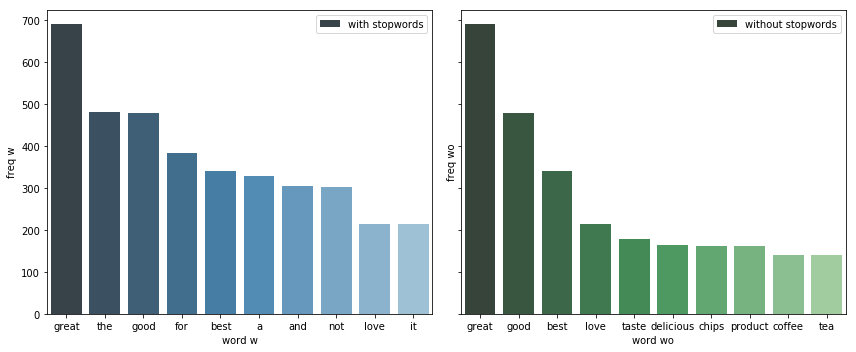

In [43]:
fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(12,5))
sns.barplot(x=fdist_w['word w'][:10], 
            y=fdist_w['freq w'][:10],
            palette='Blues_d',ax=ax1,label='with stopwords')

sns.barplot(x=fdist_wo['word wo'][:10], 
            y=fdist_wo['freq wo'][:10],
            palette='Greens_d',ax=ax2,label='without stopwords')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


### P.S. 热门短语

In [44]:
from nltk import ngrams

In [45]:
def get_ngrams(text,n=2):
    return ngrams(text,n)

In [46]:
s = 'what is your name'
s_token = word_tokenize(s)
list(get_ngrams(s_token))

[('what', 'is'), ('is', 'your'), ('your', 'name')]

In [47]:
bigram_w = []
for token in corpus_w_stopword:
    bigram = nltk.bigrams(token)
    for item in bigram:
        bigram_w.append(item)
bigram_wo = []
for token in corpus_wo_stopword:
    bigram = nltk.bigrams(token)
    for item in bigram:
        bigram_wo.append(item)

In [48]:
FreqDist(bigram_w).most_common(10)

[(('the', 'best'), 139),
 (('great', 'product'), 64),
 (('dog', 'food'), 60),
 (('love', 'it'), 58),
 (('great', 'for'), 51),
 (('gluten', 'free'), 48),
 (('very', 'good'), 47),
 (('love', 'this'), 44),
 (('hot', 'cocoa'), 43),
 (('a', 'great'), 42)]

In [49]:
FreqDist(bigram_wo).most_common(10)

[(('great', 'product'), 64),
 (('dog', 'food'), 60),
 (('gluten', 'free'), 48),
 (('hot', 'cocoa'), 43),
 (('great', 'taste'), 36),
 (('hot', 'chocolate'), 33),
 (('pretty', 'good'), 31),
 (('great', 'price'), 25),
 (('pop', 'chips'), 25),
 (('great', 'tasting'), 24)]

In [50]:
bi_fq_w = pd.DataFrame(list(FreqDist(bigram_w).items()), columns=['bi_w','bicounts_w'])
bi_fq_wo = pd.DataFrame(list(FreqDist(bigram_wo).items()), columns=['bi_wo','bicounts_wo'])

In [51]:
bi_fq_w.sort_values(by='bicounts_w',inplace=True,ascending=False)
bi_fq_wo.sort_values(by='bicounts_wo',inplace=True,ascending=False)

In [52]:
bi_fq_w.head()

,bi_w,bicounts_w
22,"(the, best)",139
425,"(great, product)",64
2,"(dog, food)",60
56,"(love, it)",58
173,"(great, for)",51


In [53]:
bi_fq_wo.head()

,bi_wo,bicounts_wo
277,"(great, product)",64
2,"(dog, food)",60
52,"(gluten, free)",48
4806,"(hot, cocoa)",43
68,"(great, taste)",36


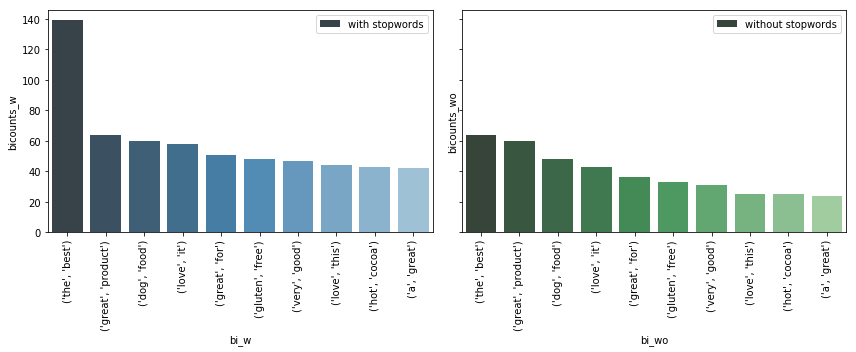

In [54]:
fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(12,5))
sns.barplot(x=bi_fq_w['bi_w'][:10], 
            y=bi_fq_w['bicounts_w'][:10],
            palette='Blues_d',ax=ax1,label='with stopwords')

sns.barplot(x=bi_fq_wo['bi_wo'][:10], 
            y=bi_fq_wo['bicounts_wo'][:10],
            palette='Greens_d',ax=ax2,label='without stopwords')

ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(),rotation=90)
ax2.set_xticklabels(ax1.xaxis.get_majorticklabels(),rotation=90)

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 4.4 Modeling
### 4.4.1 Data processing

In [55]:
def stem_tokens(tokens, stemmer = PorterStemmer()):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed     
    
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens)
    return ' '.join(stems)

def build_corpus(dataset):
    corpus = []
    for text in dataset:
        corpus.append(tokenize(text))
    return corpus


In [120]:
n = 10000
X = summary[:n]
y = label[:n]

In [121]:
# seed = 2018
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/5, random_state=seed)

In [124]:
X_tokens = build_corpus(X)

In [126]:
X_tfidf_vec = tfidf_vec.fit_transform(X_tokens)

In [130]:
# for i in X_tfidf_vec:
#     print(i)
#     print('-----------------')

In [133]:
len(tfidf_vec.get_feature_names())

3951

In [134]:
seed = 2018
X_train,X_test,y_train,y_test = train_test_split(X_tfidf_vec,y,test_size=1/5, random_state=seed)

In [135]:
X_train.shape

(8000, 3951)

In [136]:
X_test.shape

(2000, 3951)

In [137]:
lr1 = LogisticRegression().fit(X_train,y_train)
ypred_lr1 = lr.predict(X_test)

ValueError: X has 3951 features per sample; expecting 4232

- build corpus

In [59]:
train_token = build_corpus(X_train)
test_token = build_corpus(X_test)

In [60]:
train_token

['thi gadget just doesnt do the job',
 'more hotspici than mccormick brand',
 'realli good juic',
 'quit good',
 'hot',
 'not healthi but they tast good',
 'the best gluten free bake mix',
 'highli recommend cat food',
 'love it',
 'unremark',
 'filler food is empti leav your cat alway need more',
 'not realli oliv juic',
 'low calori snack',
 'best chocol drink ever',
 'veri good but too expens',
 'horribl',
 'veri disappoint',
 'low calori tasti snack',
 'basket delight',
 'somewhat disappoint',
 'tast great less lard',
 'yummo i am a coffe purist',
 'best dog foodno ear infect',
 'great for cake',
 'best bar mix avail',
 'tasti but expens',
 'cat grass',
 'just like i remeb',
 'quit delici but not as good as real chip',
 'wolfgang kcup',
 'ground fennel seed',
 'use it everi day',
 'delici but packag could be smaller',
 'the onli thing i have ever been addict toothes chip',
 'fluffi white popcorn',
 'amaz tea flavor energi',
 'great treat',
 'the best i bought on amazon so far',
 'm

In [119]:
FreqDist(train_token).most_common(10)

[('delici', 85),
 ('yummi', 71),
 ('great product', 54),
 ('yum', 49),
 ('great', 41),
 ('love it', 40),
 ('great coffe', 36),
 ('excel', 29),
 ('good stuff', 27),
 ('the best', 24)]

In [63]:
FreqDist(test_token).most_common(10)

[('delici', 24),
 ('yummi', 24),
 ('great product', 14),
 ('the best', 12),
 ('great', 10),
 ('good stuff', 9),
 ('awesom', 8),
 ('great coffe', 8),
 ('yum', 7),
 ('tast great', 7)]

### 4.4.2 进一步处理，计算单词出现的tf-idf频率：sklearn TfidfVectorizer (会用就行)

1. 什么是TF-IDF？

2. TF: term frequency 具体单词在某篇文章中的出现次数 
3. $TF_{词i,文章j} = \frac{词i在文章j中的频率}{文章j中所有词的频率总和}$
4. IDF: inversed document frequency 
5. $IDF_{词i} = log \frac{所有文章的篇数总和}{带有词汇i的文章篇数总和}$


In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer()

X_train_tfidf_vec = tfidf_vec.fit_transform(X_train)
X_test_tfidf_vec = tfidf_vec.fit_transform(X_test)

In [65]:
X_train_tfidf_vec.shape

(8000, 4232)

In [66]:
X_test_tfidf_vec.shape

(2000, 1973)

In [132]:
# for i in X_train_tfidf_vec:
#     print(i)
#     print('-----')

```
  (0, 3735)	0.24360750414756793
  (0, 1513)	0.5264995990860638
  (0, 1999)	0.2989781532488511
  (0, 1104)	0.4052683954906568
  (0, 1101)	0.3660027557635365
  (0, 3710)	0.1961331160269636
  (0, 1985)	0.4872339593589434
-----
  (0, 2416)	0.3600227421436003
  (0, 1824)	0.5413846747034812
  (0, 3705)	0.3279826020594771
  (0, 2286)	0.5413846747034812
  (0, 469)	0.42025742810580885
-----
  (0, 3010)	0.6169147139875941
  (0, 1588)	0.3669133633753244
  (0, 1991)	0.6962692147741503
-----
```

In [67]:
len(tfidf_vec.get_feature_names())

1973

['08',
 '081fl',
 '10',
 '100',
 '12',
 '16',
 '16ounce',
 '1866',
 '18month',
 '20',
 '200',
 '2199',
 '234',
 '24ounc',
 '2nd',
 '41',
 '45',
 '4oz',
 '50',
 '5hour',
 '6oz',
 '8ounce',
 '99',
 'about',
 'absolute',
 'absolutely',
 'absotively',
 'acceptable',
 'accurate',
 'acidic',
 'acquired',
 'across',
 'action',
 'actual',
 'actually',
 'adaptor',
 'add',
 'added',
 'addicitive',
 'addicted',
 'addicting',
 'addictive',
 'additions',
 'adds',
 'adequate',
 'adults',
 'advertised',
 'advertising',
 'afforable',
 'afford',
 'after',
 'afternoon',
 'aftertaste',
 'again',
 'agar',
 'agave',
 'agree',
 'ahhhh',
 'ahoy',
 'air',
 'alcoholic',
 'alergias',
 'alimenticias'

### 4.4.3 调用具体模型 train & predict

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [69]:
lr = LogisticRegression().fit(X_train_tfidf_vec,y_train)
ypred_lr = lr.predict(X_test_tfidf_vec)

ValueError: X has 1973 features per sample; expecting 4232

```
--------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-141-f5dd3b405b41> in <module>()
      1 lr = LogisticRegression().fit(X_train_tfidf_vec,y_train)
----> 2 ypred_lr = lr.predict(X_test_tfidf_vec)

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py in predict(self, X)
    322             Predicted class label per sample.
    323         """
--> 324         scores = self.decision_function(X)
    325         if len(scores.shape) == 1:
    326             indices = (scores > 0).astype(np.int)

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py in decision_function(self, X)
    303         if X.shape[1] != n_features:
    304             raise ValueError("X has %d features per sample; expecting %d"
--> 305                              % (X.shape[1], n_features))
    306 
    307         scores = safe_sparse_dot(X, self.coef_.T,

ValueError: X has 1973 features per sample; expecting 4232
```

# Issue - LogisticRegression

Error should come out from data processing

because of there is not a np.hstack() list for each word

In [70]:
# Data processing

def stem_tokens_1(tokens, stemmer = PorterStemmer()):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed     
    
def tokenize_1(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens_1(tokens)
    return ' '.join(stems)

def build_corpus_1(dataset):
    corpus = []
    for text in dataset:
        corpus.append(tokenize_1(text))
    return corpus

In [73]:
X1 = summary[:5000]
y1 = label[:5000]

In [76]:
X1.head()

0    good quality dog food
1        not as advertised
2      delight says it all
3           cough medicine
4              great taffy
Name: Summary, dtype: object

In [77]:
X1_corpus = build_corpus_1(X1)

In [78]:
X1_corpus

['good qualiti dog food',
 'not as advertis',
 'delight say it all',
 'cough medicin',
 'great taffi',
 'nice taffi',
 'great just as good as the expens brand',
 'wonder tasti taffi',
 'yay barley',
 'healthi dog food',
 'the best hot sauc in the world',
 'my cat love thi diet food better than their regular food',
 'my cat are not fan of the new food',
 'fresh and greasi',
 'strawberri twizzler yummi',
 'lot of twizzler just what you expect',
 'poor tast',
 'love it',
 'great sweet candi',
 'home deliv twizler',
 'alway fresh',
 'twizzler',
 'delici product',
 'twizzler',
 'pleas sell these in mexico',
 'twizzler strawberri',
 'nasti no flavor',
 'great bargain for the price',
 'yummi',
 'the best hot sauc in the world',
 'great machin',
 'thi is my tast',
 'best of the instant oatmeal',
 'good instant',
 'great irish oatmeal for those in a hurri',
 'satisfi',
 'love gluten free oatmeal',
 'it oatmeal',
 'good way to start the day',
 'wife favorit breakfast',
 'whi wouldnt you buy oatm

In [114]:
def make_corpus(data):
    tokens = nltk.word_tokenize(data)
    tokens_no_stpwords = [word for word in tokens if word not in stopwords.words('english')]
    tokens_no_h = np.hstack(tokens_no_stpwords)    
    stem = [PorterStemmer().stem(word) for word in tokens_no_h]
    return stem

In [115]:
dat = 'this will being my notebook of amazon fine food reviews'

In [116]:
make_corpus(dat)

['notebook', 'amazon', 'fine', 'food', 'review']